In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data, load_receptor_data
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, leaves_list

/usr/local/lib/python3.9/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")
/usr/local/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [4]:
project_path = "/workspaces/bha2"
conn_size = 2165
optimal_parcellation = nib.load(
    os.path.join(
        project_path,
        "data",
        "results",
        "n" + str(conn_size),
        "optimal_parcellation.nii.gz",
    )
).get_fdata()
module_sizes = nib.load(
    os.path.join(
        project_path, "data", "results", "n" + str(conn_size), "module_sizes.nii.gz"
    )
).get_fdata()
module_idx = np.setdiff1d(np.unique(optimal_parcellation), [0]).astype(int)
module_idx

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

/tmp/ipykernel_1940269/1450136505.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if m_size > 2:


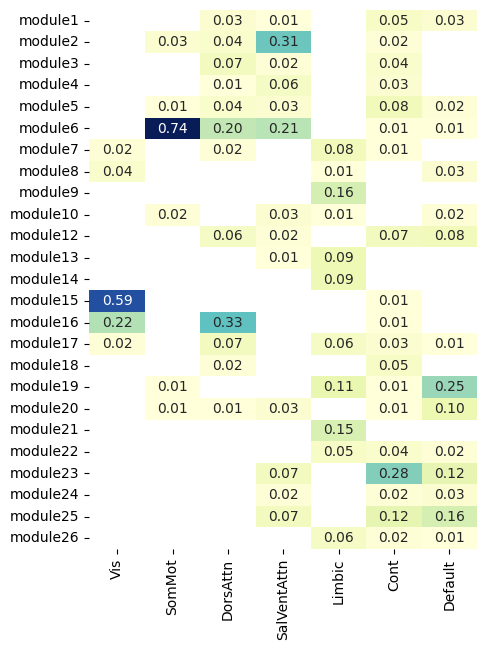

In [6]:
plt.rcParams["figure.figsize"] = (5, 7)

rsn = nib.load(
    os.path.join(project_path, "brain_templates", "atlases", "Yeo7_networks.nii.gz")
)
rsn_labels = np.loadtxt(
    os.path.join(project_path, "brain_templates", "atlases", "Yeo7_networks.txt"),
    dtype=str,
)


RSN_table = pd.DataFrame(
    columns=rsn_labels,
    index=np.array(["module" + str(i) for i in module_idx]),
    dtype=float,
)

for idx in module_idx:
    module_vol = optimal_parcellation == idx
    m_size = np.setdiff1d(np.unique(module_sizes[module_vol]), [0])
    rsn_vol = rsn.get_fdata()
    if m_size > 5:
        rsn_count = np.zeros((int(rsn_vol.max())))
        for i in range(1, int(rsn_vol.max()) + 1):
            rsn_mask = np.where(rsn_vol == i, 1, 0)
            # dice index
            # rsn_count[i - 1] = 2*(rsn_mask*module_vol).sum() / (module_vol.sum()+rsn_mask.sum())
            # single overlap
            rsn_count[i - 1] = (rsn_mask * module_vol).sum() / (rsn_mask.sum())
        RSN_table.loc["module" + str(idx)] = rsn_count
#round to 2 decimals
RSN_table = RSN_table.round(2)
RSN_table = RSN_table.replace(0.0, np.nan)
RSN_table.dropna(axis=0, how="all", inplace=True)
sns.heatmap(RSN_table, cmap="YlGnBu", cbar=False, fmt=".2f", annot=True)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "results",
        "figures",
        "optimal_parcellation_RSNs.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

/tmp/ipykernel_1940269/4183935581.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if m_size > 2:


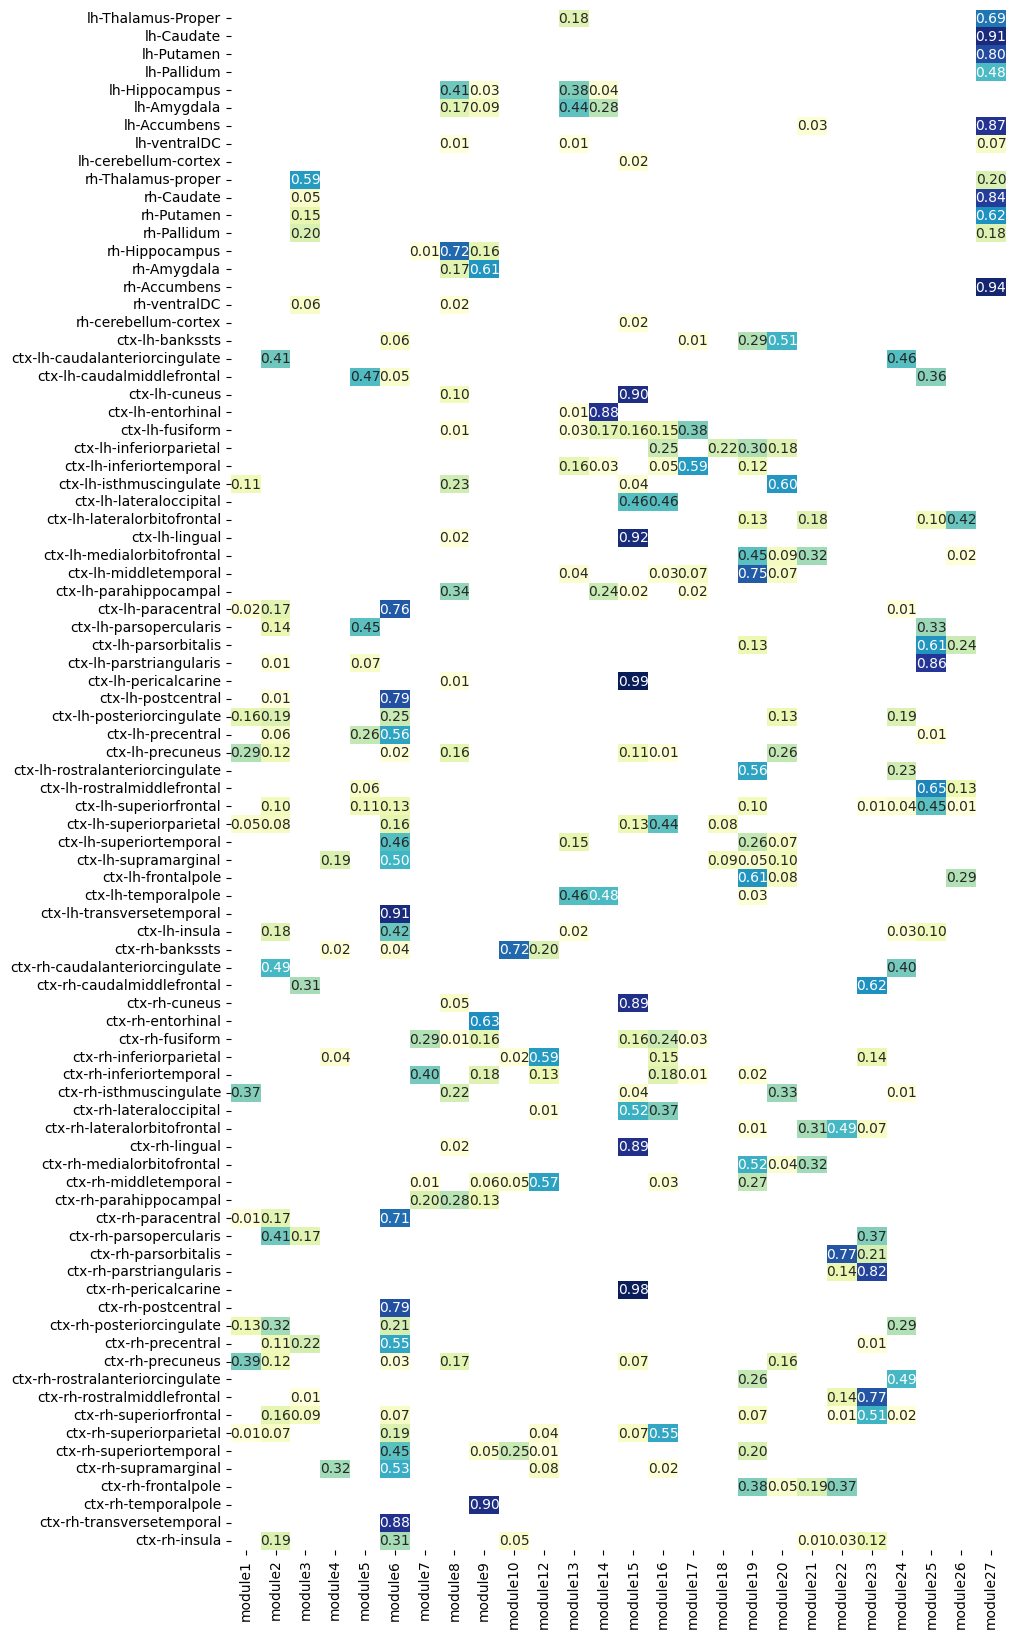

In [8]:
plt.rcParams["figure.figsize"] = (10, 20)

desikan = nib.load(
    os.path.join(project_path, "brain_templates", "atlases", "Desikan-killiany.nii.gz")
)
desikan_labels = np.loadtxt(
    os.path.join(project_path, "brain_templates", "atlases", "Desikan-killiany.txt"),
    dtype=str,
)


desikan_table = pd.DataFrame(
    columns=desikan_labels,
    index=np.array(["module" + str(i) for i in module_idx]),
    dtype=float,
)

for idx in module_idx:
    module_vol = optimal_parcellation == idx
    m_size = np.setdiff1d(np.unique(module_sizes[module_vol]), [0])
    desikan_vol = desikan.get_fdata()
    if m_size > 5:
        desikan_count = np.zeros((int(desikan_vol.max())))
        for i in range(1, int(desikan_vol.max()) + 1):
            desikan_mask = np.where(desikan_vol == i, 1, 0)
            desikan_count[i - 1] = (desikan_mask * module_vol).sum() / (
                desikan_mask.sum()
            )
        desikan_table.loc["module" + str(idx)] = desikan_count
desikan_table = desikan_table.round(2)
desikan_table = desikan_table.replace(0.0, np.nan)
desikan_table.dropna(axis=0, how="all", inplace=True)
sns.heatmap(
    pd.DataFrame.transpose(desikan_table),
    cmap="YlGnBu",
    cbar=False,
    fmt=".2f",
    annot=True,
)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "results",
        "figures",
        "optimal_parcellation_anatomy.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

/tmp/ipykernel_1940269/571898741.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if m_size > 10:


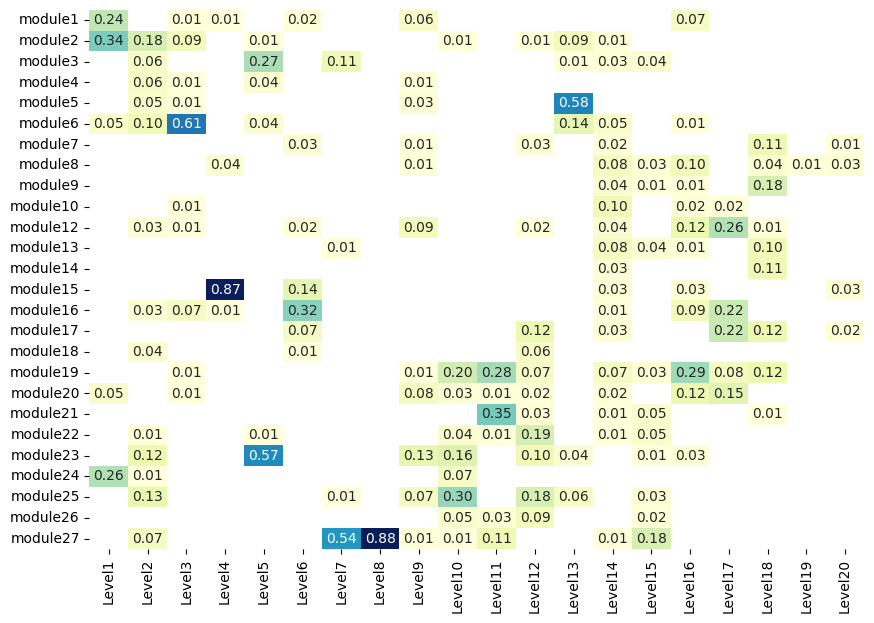

In [9]:
plt.rcParams["figure.figsize"] = (10, 7)

bha1 = nib.load(
    os.path.join(project_path, "brain_templates", "atlases", "BHA1_level20.nii.gz")
)
bha1_labels = np.loadtxt(
    os.path.join(project_path, "brain_templates", "atlases", "BHA1_level20.txt"),
    dtype=str,
)


bha1_table = pd.DataFrame(
    columns=bha1_labels,
    index=np.array(["module" + str(i) for i in module_idx]),
    dtype=float,
)

for idx in module_idx:
    module_vol = optimal_parcellation == idx
    m_size = np.setdiff1d(np.unique(module_sizes[module_vol]), [0])
    bha1_vol = bha1.get_fdata()
    if m_size > 5:
        bha1_count = np.zeros((int(bha1_vol.max())))
        for i in range(1, int(bha1_vol.max()) + 1):
            bha1_mask = np.where(bha1_vol == i, 1, 0)
            bha1_count[i - 1] = (bha1_mask * module_vol).sum() / (bha1_mask.sum())
        bha1_table.loc["module" + str(idx)] = bha1_count
bha1_table = bha1_table.round(2)
bha1_table = bha1_table.replace(0.0, np.nan)
bha1_table.dropna(axis=0, how="all", inplace=True)
sns.heatmap(bha1_table, cmap="YlGnBu", cbar=False, fmt=".2f", annot=True)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "results",
        "figures",
        "optimal_parcellation_BHA1.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)